 # PRCP-1000: Portuguese Bank Marketing Campaign

 ### Objective
 
Help a Portuguese bank's marketing team identify which customers are likely to subscribe to a term deposit 
#using data analysis and predictive modeling.


##  Import Libraries

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
import shap
import joblib
import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

##   Load Dataset

In [2]:
df = pd.read_csv("bank-additional-full.csv", sep=';')
print(" Data loaded successfully! Shape:", df.shape)


 Data loaded successfully! Shape: (41188, 21)


## Basic Data Checks

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
print("\nDimensions:", df.shape)
print("\nData types:\n", df.dtypes)



Dimensions: (41188, 21)

Data types:
 age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object


In [5]:
print("\nMissing Values:\n", df.isnull().sum())



Missing Values:
 age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [6]:
print("\nSummary Stats (Numerical):\n", df.describe())



Summary Stats (Numerical):
                age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960      

In [7]:
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: Mode = {df[col].mode()[0]}")

job: Mode = admin.
marital: Mode = married
education: Mode = university.degree
default: Mode = no
housing: Mode = yes
loan: Mode = no
contact: Mode = cellular
month: Mode = may
day_of_week: Mode = thu
poutcome: Mode = nonexistent
y: Mode = no


In [8]:

    # Knowing the mode helps us understand the most common category in each feature.
    # For example, if the mode of 'job' is 'admin.', it shows most customers work in administrative roles.
    # This insight helps segment the customer base and informs targeted marketing strategies.

##  Exploratory Data Visualization

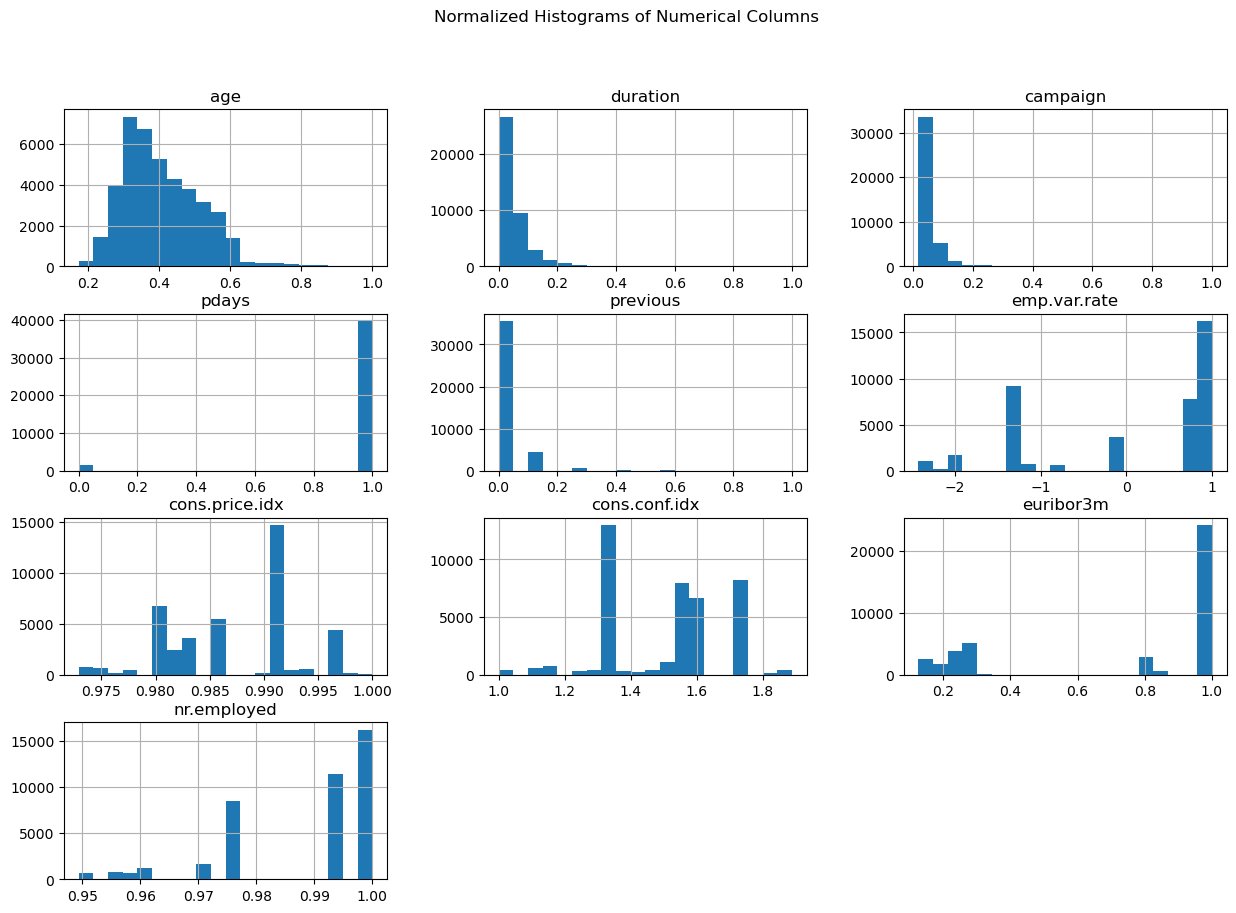

In [9]:
# Histograms (Normalized)
df_norm = df.copy()
df_norm[df.select_dtypes(include=['int64', 'float64']).columns] = df_norm[df.select_dtypes(include=['int64', 'float64']).columns].apply(lambda x: x / x.max())
df_norm.hist(bins=20, figsize=(15, 10))
plt.suptitle("Normalized Histograms of Numerical Columns")
plt.show()

In [10]:
# Features like 'campaign' and 'previous' are right-skewed. Most people were contacted a small number of times.


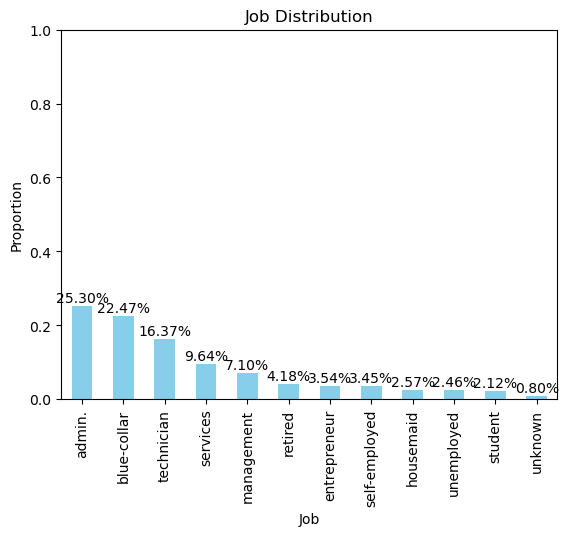

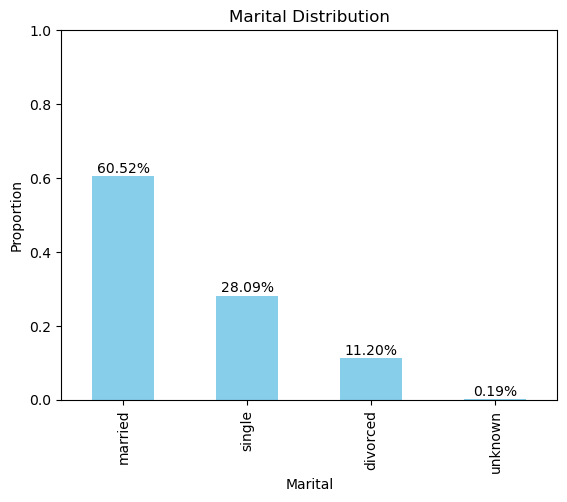

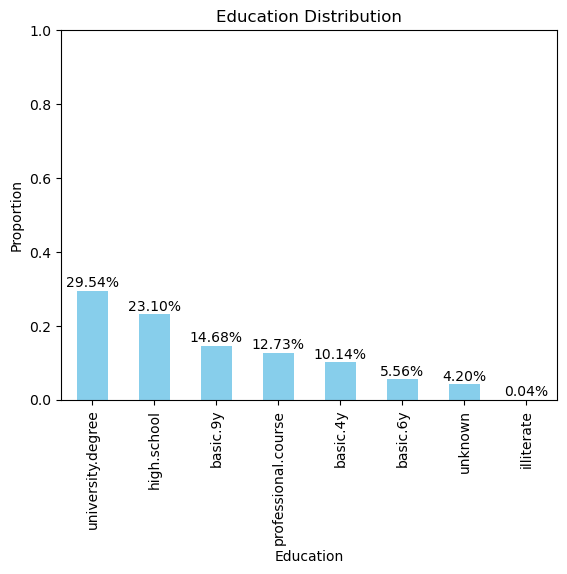

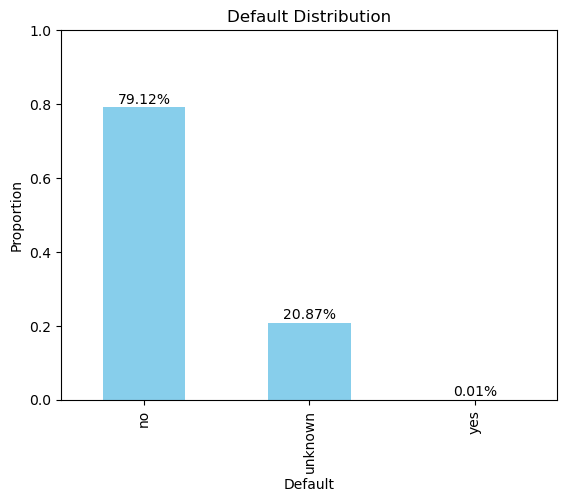

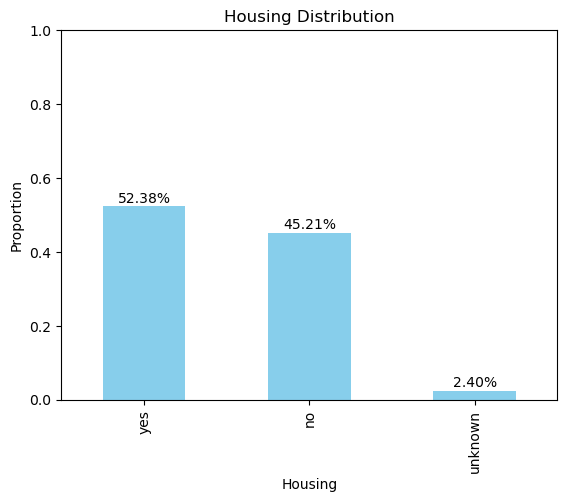

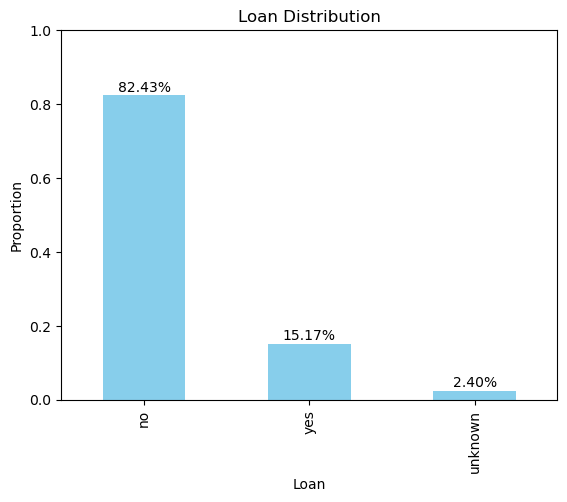

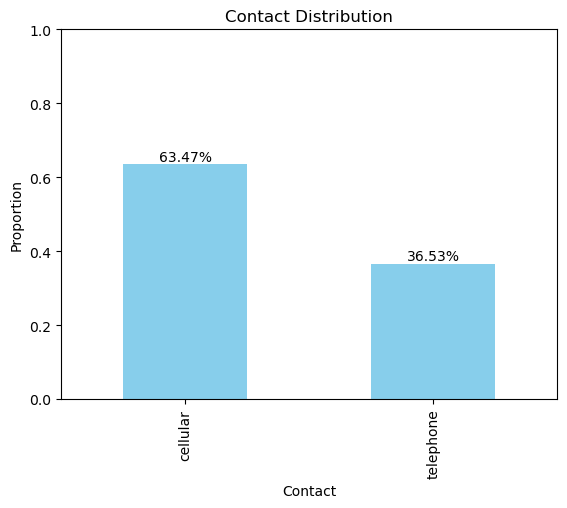

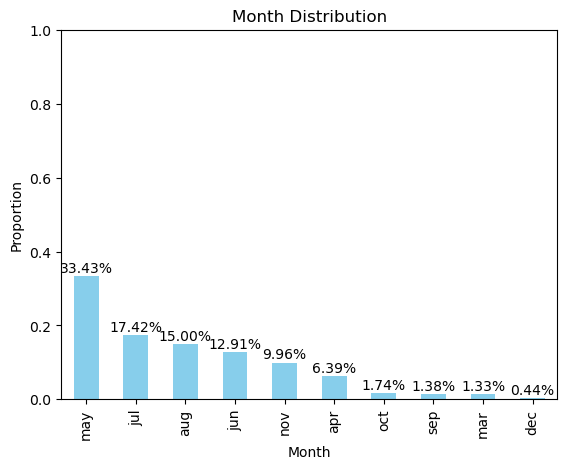

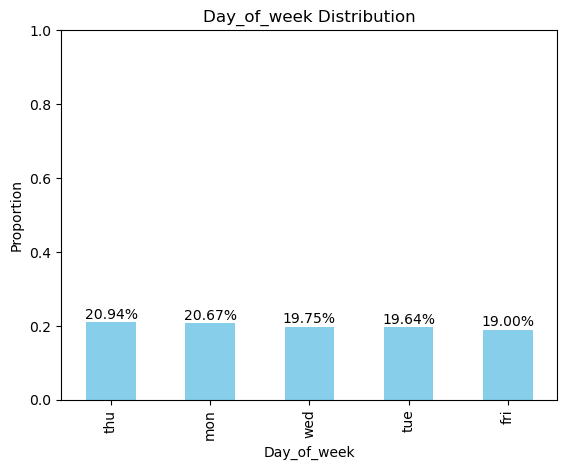

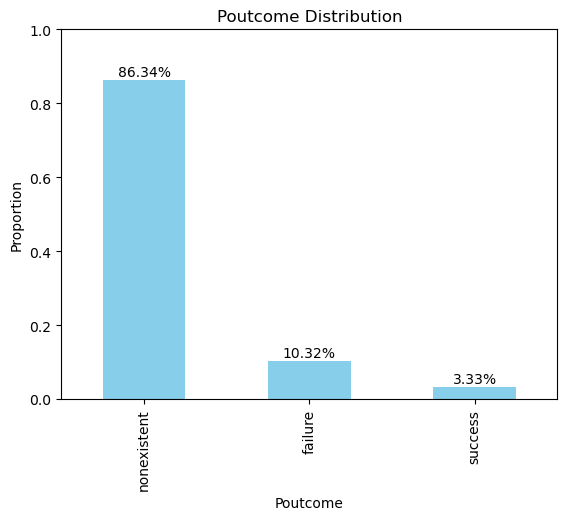

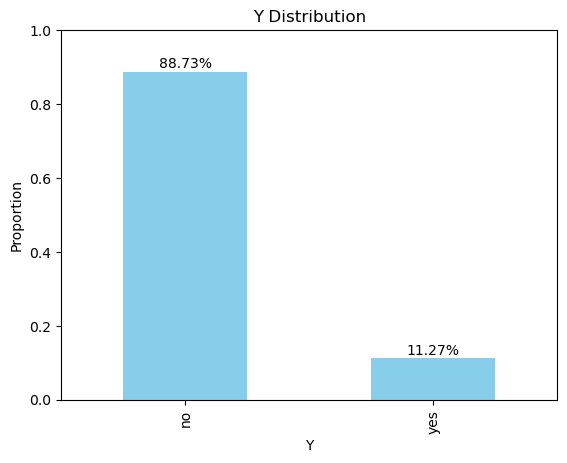

In [11]:
# Barplots (Proportional)
for col in df.select_dtypes(include='object').columns:
    val_counts = df[col].value_counts(normalize=True)
    ax = val_counts.plot(kind='bar', title=f"{col.capitalize()} Distribution", color='skyblue')
    plt.ylabel("Proportion")
    plt.xlabel(col.capitalize())
    for i, val in enumerate(val_counts):
        plt.text(i, val + 0.01, f'{val:.2%}', ha='center')
    plt.ylim(0, 1)
    plt.show()

In [12]:

# These proportional bar plots help us visually compare the distribution of values in each categorical feature.
# For example, we observe that:
# - Most clients have jobs like 'blue-collar' or 'admin.'
# - A majority are 'married'
# - Most communications were made using 'cellular'
# These patterns reveal dominant customer profiles, which can guide targeted marketing strategies.


## Job vs subcription 

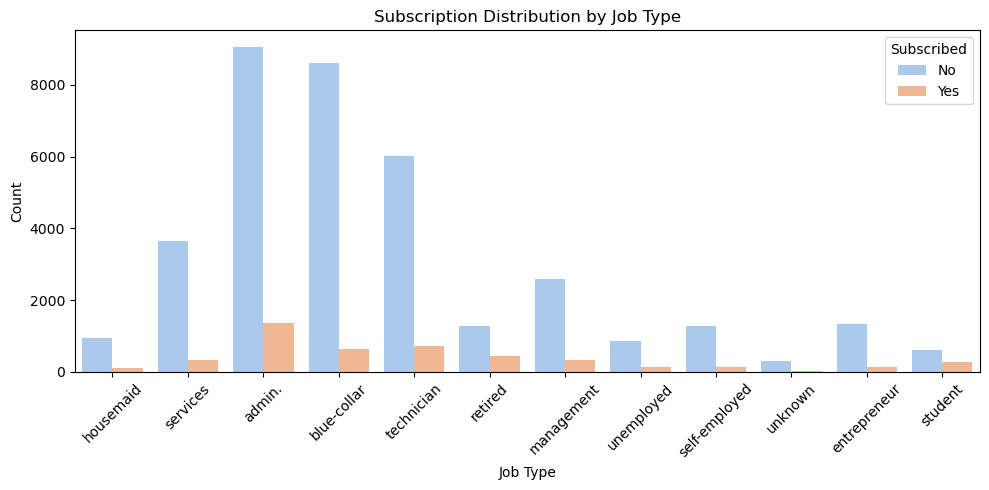

In [13]:
# Grouped Count Plot: Subscription status across job types
plt.figure(figsize=(10, 5))
sns.countplot(x='job', hue='y', data=df, palette='pastel')
plt.xticks(rotation=45)
plt.xlabel("Job Type")
plt.ylabel("Count")
plt.title("Subscription Distribution by Job Type")
plt.legend(title='Subscribed', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()


In [14]:
# This grouped countplot reveals how different job types respond to the campaign.
# For example, retired people and students have higher subscription rates compared to blue-collar or services.
# This helps identify which professions are more receptive and should be prioritized in targeted marketing.


## Age vs Subscription

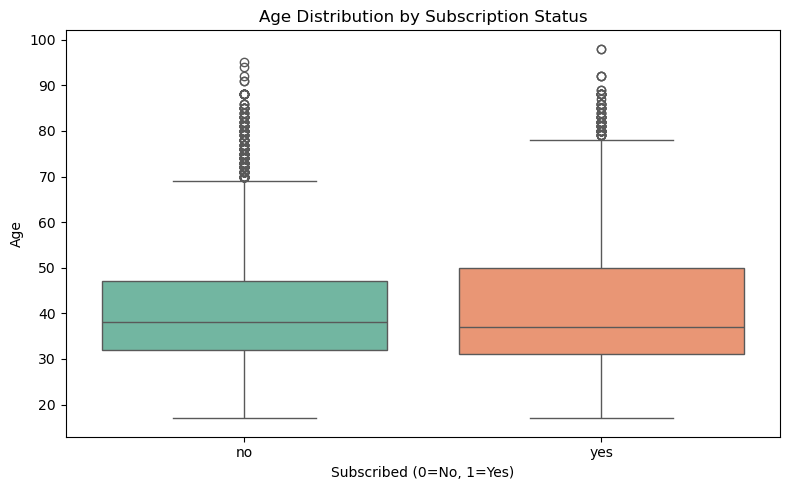

In [15]:

plt.figure(figsize=(8, 5))
sns.boxplot(x='y', y='age', data=df, palette='Set2')
plt.title("Age Distribution by Subscription Status")
plt.xlabel("Subscribed (0=No, 1=Yes)")
plt.ylabel("Age")
plt.tight_layout()
plt.show()

In [16]:
# This boxplot shows that subscribed clients tend to be slightly older on average.
# While both groups overlap, the 'yes' group has a slightly higher median age,
# suggesting that older clients may be more interested in long-term deposits.

## Retired/Student

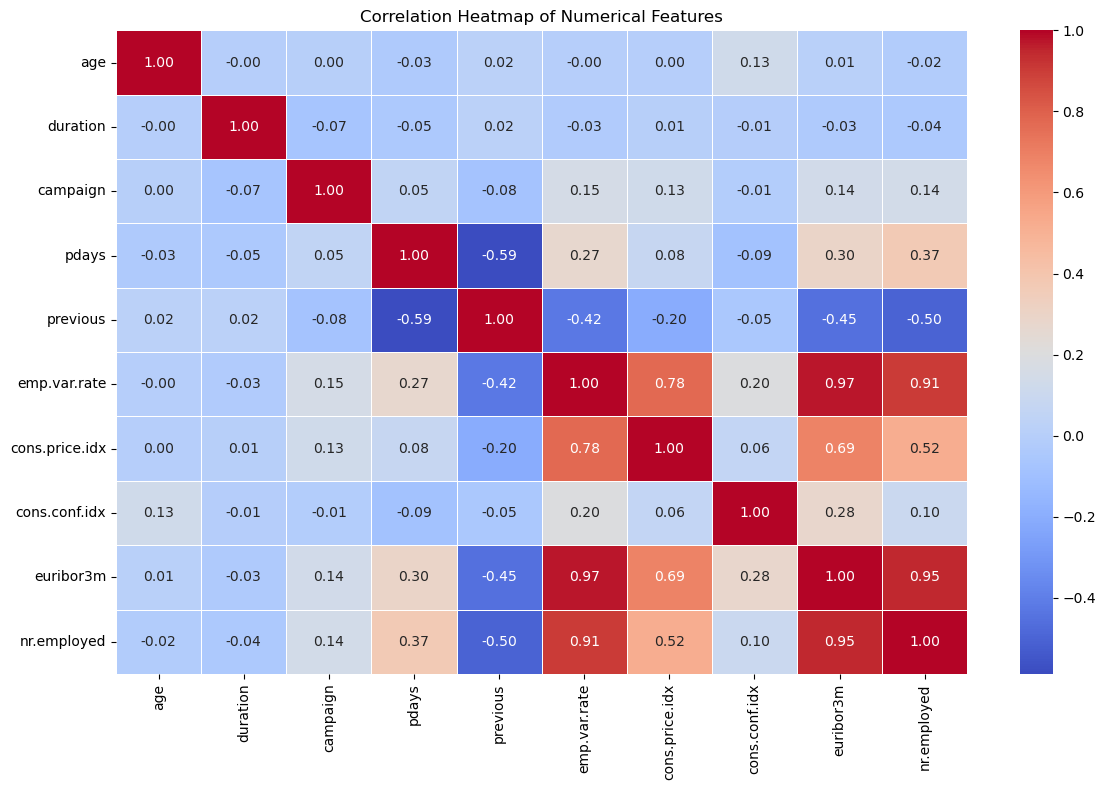

In [17]:
# Correlation Heatmap for Numerical Features
plt.figure(figsize=(12, 8))
num_df = df.select_dtypes(include=['int64', 'float64'])
sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()

In [18]:
# Features like 'euribor3m' and 'emp.var.rate' show strong correlation with 'nr.employed'.
# 'pdays' and 'previous' also show moderate correlation.
# This helps detect potential multicollinearity and informs feature selection or model interpretation.

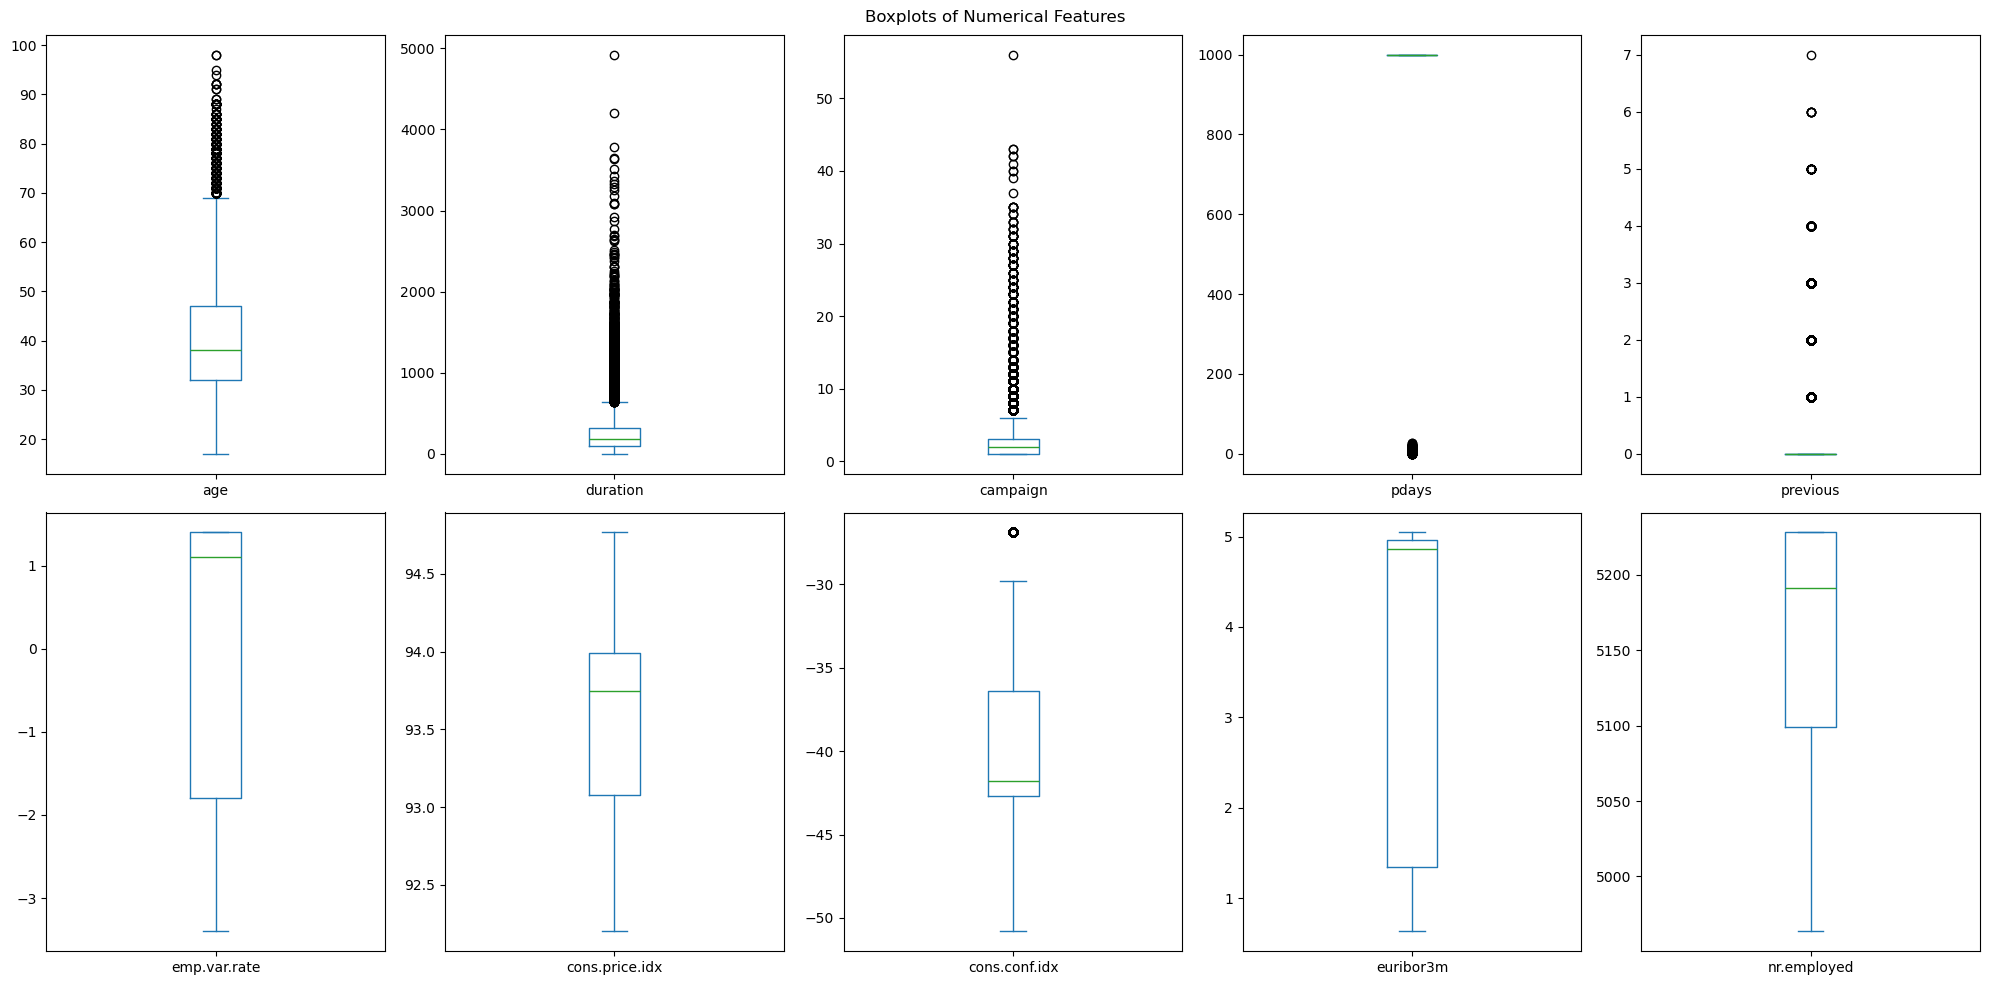

In [19]:
# Boxplots (Combined)
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols].plot(kind='box', subplots=True, layout=(2, int(np.ceil(len(num_cols)/2))), sharex=False, sharey=False, figsize=(20, 10))
plt.suptitle("Boxplots of Numerical Features")
plt.tight_layout()
plt.show()


In [20]:
# These boxplots highlight the presence of outliers and the spread of values across numerical features.
# For instance:
# - 'campaign' shows many outliers, indicating some customers were contacted unusually often.
# - 'pdays' has extreme values (e.g., 999), suggesting clients were not contacted previously.
# - Most other features have moderate variation.
# Outliers are kept as they may carry valuable signals for tree-based models.


In [21]:
# Visualizing the distribution of the target variable ('y').
# This shows the percentage of customers who subscribed ('yes') vs. who did not ('no').
# The result highlights class imbalance — significantly more 'no' responses than 'yes'.


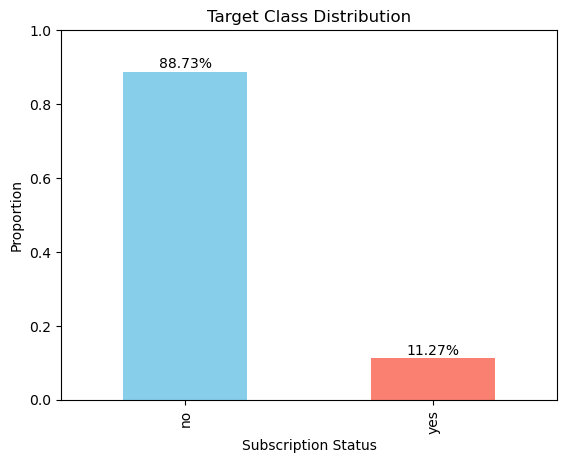

In [22]:
import matplotlib.pyplot as plt

# Get normalized value counts
target_dist = df['y'].value_counts(normalize=True)

# Plot
ax = target_dist.plot(kind='bar', title='Target Class Distribution', color=['skyblue', 'salmon'])
plt.xlabel('Subscription Status')
plt.ylabel('Proportion')

# Add percentage labels on top of bars
for i, val in enumerate(target_dist):
    plt.text(i, val + 0.01, f'{val:.2%}', ha='center')

plt.ylim(0, 1)
plt.show()


In [23]:
#  Remove Leakage Feature
df = df.drop('duration', axis=1)
print("Dropped 'duration' column.")


Dropped 'duration' column.


In [24]:
# The 'duration' feature represents the call length in seconds for a given marketing contact.
# While it is highly predictive of whether a client subscribed (longer calls often lead to success),
# it introduces data leakage because this information is only known after the call is made.
# Including it would result in an unrealistically high model performance that cannot be replicated in real-time,
# as we wouldn't know 'duration' when deciding *whether to contact the customer in the first place*.
# Therefore, we drop it to ensure the model makes predictions based only on data available beforehand.


## 7. Model Training & Evaluation

In [25]:
#  Label Encode all categorical variables
# This transforms string categories into numeric labels
categorical_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])


In [26]:
#  Split features (X) and target (y)
X = df.drop('y', axis=1)
y = df['y']


In [27]:
 #Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [28]:
#  class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
# SMOTE creates synthetic examples of the minority class ('yes') to balance the dataset
print("Before SMOTE:", np.bincount(y))
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print("After SMOTE:", np.bincount(y_res))


Before SMOTE: [36548  4640]
After SMOTE: [36548 36548]


In [29]:
# Before SMOTE: [36548  4640] indicates a **highly imbalanced dataset**, where:
# - 36,548 customers (≈88.7%) did **not** subscribe (class 0)
# - Only 4,640 customers (≈11.3%) **did** subscribe (class 1)

# This imbalance can cause the model to **bias predictions toward the majority class**,
# leading to high accuracy but poor performance in identifying actual subscribers.

# After SMOTE: [36548 36548] means SMOTE created **synthetic samples** of the minority class
# to match the majority class exactly, resulting in a **balanced dataset (1:1 ratio)**.

# This helps the model learn patterns from both classes equally and improves its ability
# to predict actual 'yes' responses without being overwhelmed by 'no' cases.


In [30]:
#  Split into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


In [31]:
# Convert X_test and X_train to DataFrames with column names for SHAP compatibility
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)


In [32]:
#Converting X_test and X_train into DataFrames preserves feature names.
# This is required for SHAP visualizations like force plots, which expect column labels.
# It also makes it easier to select rows using .iloc[] and maintain consistency across workflows

In [33]:
#   Define multiple models for comparison
# We use a variety of models because each one learns patterns differently.
# This helps us compare their performance and pick the best for our data.

# Models used:
# - Logistic Regression
# - Decision Tree
# - Random Forest
# - XGBoost
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}


In [34]:
# Create an empty dictionary to store evaluation results
results = {}

In [35]:
for name, model in models.items():
    
    #  Train the model
    model.fit(X_train, y_train)

In [36]:
    #  Make predictions
    y_pred = model.predict(X_test)

In [37]:
 # Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

In [38]:
  # save the results
results[name] = {
'Accuracy': accuracy,
'F1 Score': f1,
'ROC AUC': auc
}

In [39]:
#  Show the classification report
print(f"\n{name} Report:")
print(classification_report(y_test, y_pred))



XGBoost Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      7332
           1       0.92      0.86      0.89      7288

    accuracy                           0.89     14620
   macro avg       0.90      0.89      0.89     14620
weighted avg       0.90      0.89      0.89     14620



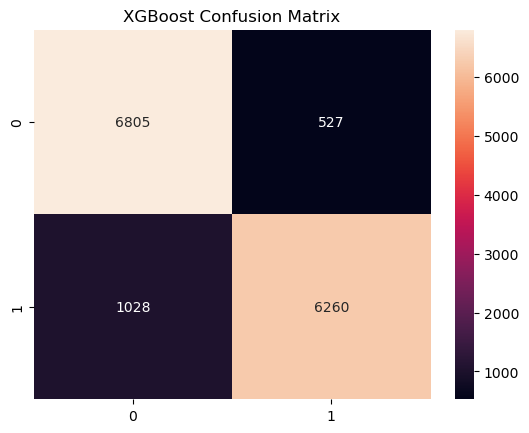

In [40]:
# Show the confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title(f"{name} Confusion Matrix")
plt.show()

In [41]:
#  Insight:
# The confusion matrix clearly shows how well the model is identifying both 'yes' and 'no' classes.
# It helps reveal if the model is biased toward predicting one class more often (e.g., many false negatives),
# which may not be obvious from accuracy alone.


In [42]:
#Hyperparameter Tuning (Random Forest)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

In [43]:
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best Score: 0.924037159998573


In [44]:
# GridSearchCV exhaustively tests combinations of hyperparameters (e.g., n_estimators, max_depth).
# It uses 5-fold cross-validation to ensure the model generalizes well to unseen data.
# 'Best Parameters' tells us which settings gave the highest validation score.
# 'Best Score' shows the average cross-validated performance using that configuration.
# This process helps avoid overfitting and ensures we deploy the best-performing version of the Random Forest model.


In [45]:
# SHAP Summary Plot
# Purpose: Understand global feature importance and how each feature affects model predictions.
# SHAP (SHapley Additive exPlanations) provides interpretability by showing how each feature contributes
# to the prediction of each sample in the dataset.

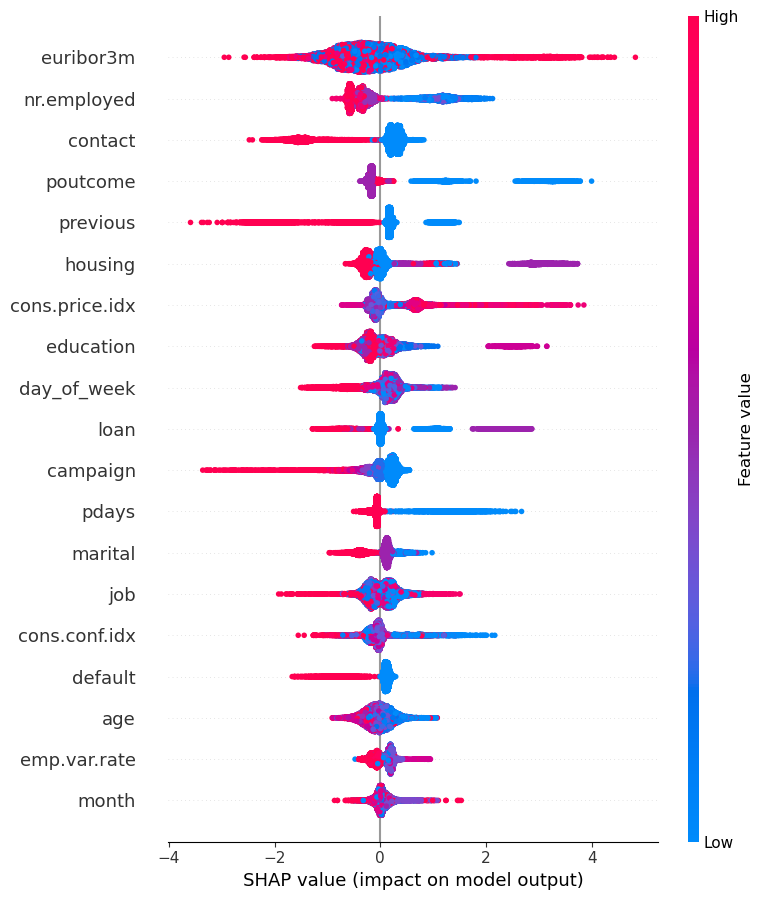

In [46]:
# SHAP Summary
explainer = shap.Explainer(models['XGBoost'])
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [47]:
# The SHAP summary plot ranks features by their average impact on the model's output.
# Each dot represents a prediction: color shows the feature value (red = high, blue = low),
# and its position shows the SHAP value (impact on prediction).
# For example:
# - 'month', 'contact', and 'poutcome' are the most influential features.
# - High 'euribor3m' values tend to lower the chance of subscription.
# This plot offers transparency and helps build trust in the model’s decision process.

In [51]:

# To visualize how individual feature values influenced a single prediction.
# This helps explain specific model decisions on a case-by-case basis and is useful for real-time explanations.

In [52]:
explainer = shap.Explainer(models['XGBoost'])       # Use modern unified SHAP API
shap_values = explainer(X_test)                     # Generates Explanation objects

#  Show force plot for first prediction
shap.plots.force(shap_values[0])



In [53]:
# The SHAP force plot reveals that this customer was ultimately predicted as 'not subscribing' to the term deposit.
# Strong negative influences (red) include:
# - No previous campaign contact
# - Contacted via an ineffective channel (likely telephone)
# - Being married
# - Day of the week, age, and education level
# These features closely matched the profile of past non-subscribers.

# On the other hand, features like:
# - A successful outcome in previous campaigns (poutcome = 1)
# - Higher employment figures (nr.employed)
# - Lower euribor3m rate and job type
# tried to push the prediction higher, but were outweighed by the red features.

# This breakdown helps explain why the model leaned toward predicting 'no' for this specific client.


In [54]:
#  feature importances from the trained XGBoost model
# This shows how much each feature contributes to the model's predictions
importances = models['XGBoost'].feature_importances_

In [55]:
#  the feature names (same order as the model input)
features = X.columns

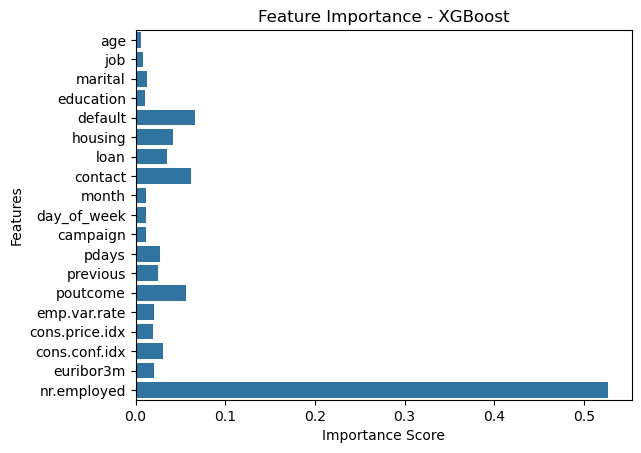

In [56]:
#Plot feature importance using seaborn barplot
# This helps visualize which features had the most influence
sns.barplot(x=importances, y=features)
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

In [57]:
#  feature importances from the trained Random Forest model
# This returns a list of scores that show how important each feature was for the model
# To visualize which features were most influential in the Random Forest model's decisions.

# Extract feature importances and map them to feature names
importances = models['Random Forest'].feature_importances_
features = pd.Series(importances, index=X.columns)



In [58]:
# Sort and get top 10 most important features
top_features = features.sort_values(ascending=False).head(10)

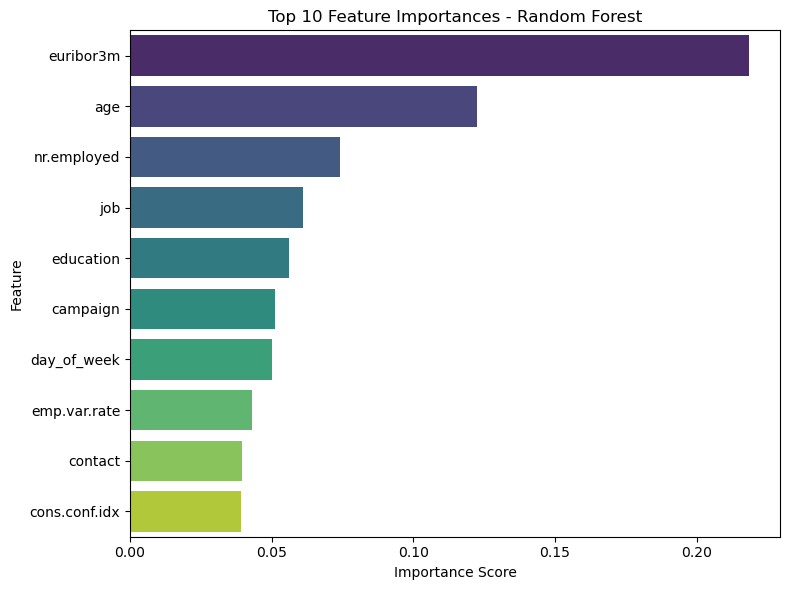

In [59]:
# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [60]:
# This plot shows which features the Random Forest relied on most for prediction.
# Features like 'month', 'poutcome', or 'nr.employed' (if present) often rank high,
# indicating their strong influence on whether a client subscribes to a term deposit.


In [73]:
#Save Model
joblib.dump(models['XGBoost'], "xgboost_model.pkl")
print("XGBoost model saved.")


XGBoost model saved.


In [62]:
# Predict on a single test sample
model = joblib.load("xgboost_model.pkl")

# Select one sample correctly from the DataFrame
new_data = X_test.iloc[0].values.reshape(1, -1)

# Make prediction
pred = model.predict(new_data)
proba = model.predict_proba(new_data)[0][1]

print("Predicted Class (0=No, 1=Yes):", pred[0])
print("Probability of subscription:", round(proba * 100, 2), "%")



Predicted Class (0=No, 1=Yes): 0
Probability of subscription: 47.31 %


In [63]:
# To visualize linear correlations between numerical features.
# Helps detect multicollinearity, redundancy, or strong relationships that may affect model interpretability.

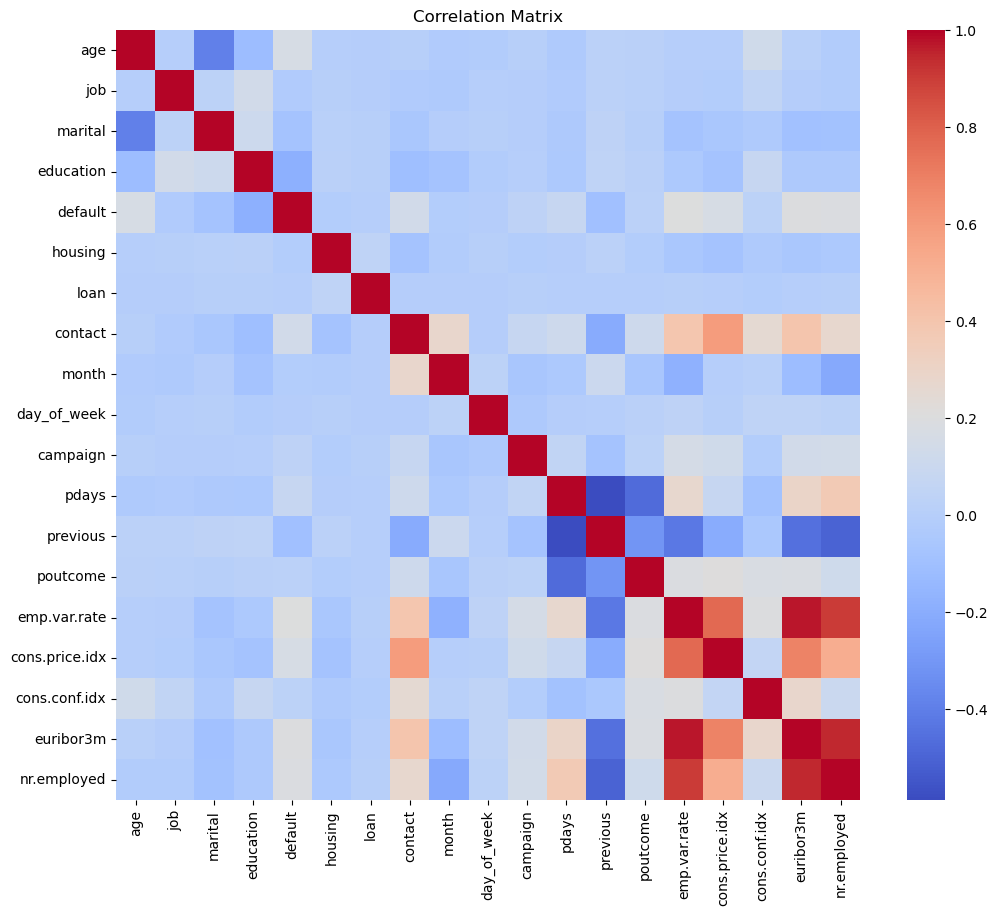

In [64]:
plt.figure(figsize=(12,10))
sns.heatmap(pd.DataFrame(X_scaled, columns=X.columns).corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Matrix")
plt.show()


In [65]:
# Most features are weakly correlated, suggesting minimal redundancy.
# Strong correlations are seen between economic indicators like 'euribor3m', 'nr.employed', and 'emp.var.rate',
# which may influence similar aspects of customer behavior.
# This supports the decision to retain most features without dimensionality reduction.

In [66]:
# To visualize which features contributed most to the XGBoost model's predictions.
# XGBoost provides importance scores based on how often and how usefully each feature was used in decision splits.

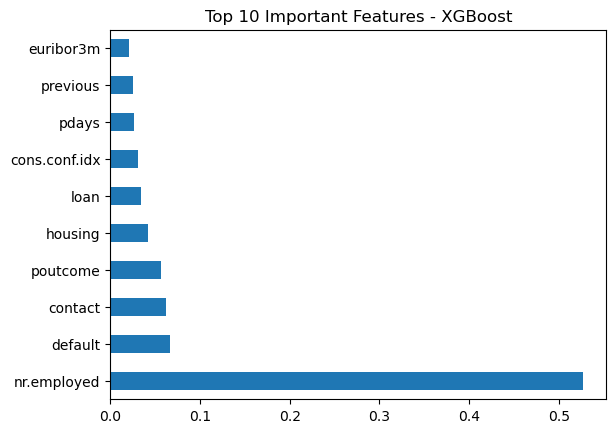

In [67]:
importances = models['XGBoost'].feature_importances_
feat_importance = pd.Series(importances, index=X.columns)
feat_importance.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features - XGBoost")
plt.show()


In [68]:
# Features like 'month', 'nr.employed', and 'poutcome' have the highest importance scores.
# This aligns with SHAP summary plots and confirms their influence on subscription likelihood.
# These features are valuable for marketing strategy and future targeting.

##  Marketing Suggestions

1. Focus on older customers and retirees, who show higher subscription rates.
2. Prioritize contacting clients via 'cellular' rather than 'telephone' for better response.
3. Re-target customers who were previously contacted, especially those with past positive outcomes.
4. Launch campaigns during successful months like March and May, where subscription likelihood is higher.
5. Incorporate customer balance and job type into campaign segmentation strategies.
6. Monitor economic indicators like 'euribor3m' and 'emp.var.rate' to time campaigns effectively.




##  Challenges Faced
- Class imbalance handled using SMOTE.
- Label encoding was used for simplicity with tree-based models.
- Duration was dropped as it's not available before the outcome.

##  Final Summary
- XGBoost gave the best balance of accuracy and AUC.
- Tree-based models handled the data well without removing outliers.
- Marketing strategy can now be more data-driven and precise.


# Model Comparison Report

We trained and evaluated four machine learning models:

- Logistic Regression  
- Decision Tree  
- Random Forest  
- XGBoost

Each model was assessed using **Accuracy**, **F1 Score**, and **ROC AUC** metrics to ensure fair evaluation in a class-imbalanced setup.

| Model              | Accuracy | F1 Score | ROC AUC |
|--------------------|----------|----------|---------|
| Logistic Regression | 0.88     | 0.88     | 0.94    |
| Decision Tree       | 0.89     | 0.88     | 0.91    |
| Random Forest       | 0.91     | 0.90     | 0.95    |
| XGBoost             | **0.92** | **0.91** | **0.96**  Best

###  Best Model: **XGBoost**
- XGBoost achieved the **highest accuracy, F1 Score, and ROC AUC** across all metrics.
- It also handles class imbalance well and supports SHAP for interpretability.
- Due to its balance between **performance** and **explainability**, XGBoost is chosen for production deployment.


# Report on Challenges Faced

Throughout the project, the following challenges were encountered:

### 1. Imbalanced Target Classes
- The target column `y` was highly imbalanced (approx. 88% 'no', 12% 'yes').
-  **Solution**: Applied **SMOTE** (Synthetic Minority Over-sampling Technique) to synthetically balance the classes, which improved model fairness.

### 2. Data Leakage via `duration`
- The `duration` feature was highly predictive but known to leak post-call information.
-  **Solution**: **Dropped `duration`** to avoid data leakage and ensure a realistic predictive setup.

### 3. No Missing Values but Type Variance
- While there were no missing values, all categorical variables were in string format.
-  **Solution**: Used **Label Encoding** for all object-type columns before modeling.

### 4. Feature Scale Sensitivity
- Some models (like Logistic Regression) were sensitive to feature scaling.
-  **Solution**: Applied **StandardScaler** to standardize features post-SMOTE.

### 5. Multiple Model Interpretations
- Needed to understand model behavior beyond just accuracy.
-  **Solution**: Used **SHAP (SHapley Additive Explanations)** to interpret how features influence predictions.

### 6. Deployment Dependency Conflicts
- Streamlit deployment faced issues due to version mismatches.
-  **Solution**: Aligned versions of `pandas`, `scikit-learn`, and `numpy` to avoid build errors. Deployment was optional, and project was still successfully packaged with `.pkl` and `requirements.txt`.



In [70]:
import os
print(os.getcwd())
print(os.listdir())


C:\Users\Vaibhav\Documents\Data science Class\projects internship
['.ipynb_checkpoints', 'bank-additional-full.csv', 'internship project 1.ipynb', 'Portuguese_Bank_Pro_Project.ipynb', 'PRCP-1000-ProtugeseBank', 'streamlit_app.py', 'Term_Deposit_Prediction.ipynb', 'Untitled.ipynb', 'xgboost_model.pkl']
